In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully ✓")

Libraries loaded successfully ✓


## 1. Load Operator Performance Data

In [13]:
# Load the parquet file with operator-level performance data
df = pd.read_parquet('warehouse/data/operator_performance.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"Days: {df['date'].nunique()}")
print(f"Operators: {df['operator'].nunique()}")
print(f"\nTier distribution:")
print(df.groupby('operator_tier')['operator'].nunique())

df.head()

Dataset shape: (8203, 9)

Columns: ['operator', 'date', 'game_category', 'GGR', 'total_stake', 'total_payout', 'total_bets', 'operator_tier', 'movement_wager_mean']

Date range: 2024-12-30 00:00:00 to 2025-12-07 00:00:00
Days: 343
Operators: 33

Tier distribution:
operator_tier
Large       5
Large+      3
Medium      6
Medium+     7
Micro       5
Small       5
Top Tier    2
Name: operator, dtype: int64


,operator,date,game_category,GGR,total_stake,total_payout,total_bets,operator_tier,movement_wager_mean
0,SAH,2024-12-30,RRI_fixedOdds,2790238.00,7081448.0,4291210.00,101.0,Medium,4.485354e+06
1,ABA,2024-12-31,RRI_fixedOdds,2229771.94,12286002.0,9898330.06,4707.0,Medium+,4.655199e+07
2,BET,2024-12-31,RRI_fixedOdds,155517.00,122522.0,4305.00,833.0,Small,1.920092e+06
3,ELD,2024-12-31,RRI_casinoGame,0.00,0.0,0.00,0.0,Medium+,6.592497e+07
4,ELD,2024-12-31,RRI_fixedOdds,2993521.00,5526866.0,2533345.00,275.0,Medium+,6.592497e+07


## 2. Create Tier-Daily Aggregates

Aggregate stake across operators within each tier for each day. This gives us tier-level time series to analyze.

In [14]:
# Aggregate to tier-daily level
tier_daily = df.groupby(['date', 'operator_tier'], as_index=False).agg({
    'total_stake': 'sum',
    'total_bets': 'sum',
    'total_payout': 'sum',
    'GGR': 'sum'
})

# Sort by tier and date for time series analysis
tier_daily = tier_daily.sort_values(['operator_tier', 'date'])

print(f"Tier-daily aggregated shape: {tier_daily.shape}")
print(f"\nRecords per tier:")
print(tier_daily.groupby('operator_tier').size())

tier_daily.head(10)

Tier-daily aggregated shape: (2324, 6)

Records per tier:
operator_tier
Large       341
Large+      283
Medium      343
Medium+     341
Micro       339
Small       335
Top Tier    342
dtype: int64


,date,operator_tier,total_stake,total_bets,total_payout,GGR
1,2024-12-31,Large,1367194.18,2238.0,1487409.24,-140415.05
7,2025-01-01,Large,1537499.00,1486.0,1363806.10,144292.90
13,2025-01-02,Large,1422517.84,2431.0,1299738.74,96579.10
19,2025-01-03,Large,849558.00,2092.0,887341.00,-46014.00
25,2025-01-04,Large,0.00,29.0,0.00,0.00
31,2025-01-05,Large,524440.00,1241.0,513664.50,2075.50
37,2025-01-06,Large,1282529.00,2347.0,1264198.14,8600.86
43,2025-01-07,Large,393766.76,1783.0,346092.56,42484.20
49,2025-01-08,Large,939914.96,1881.0,954177.96,-21063.00
55,2025-01-09,Large,3479853.16,6375.0,3126244.99,323558.17


## 3. Visual Inspection: Stake Time Series by Tier

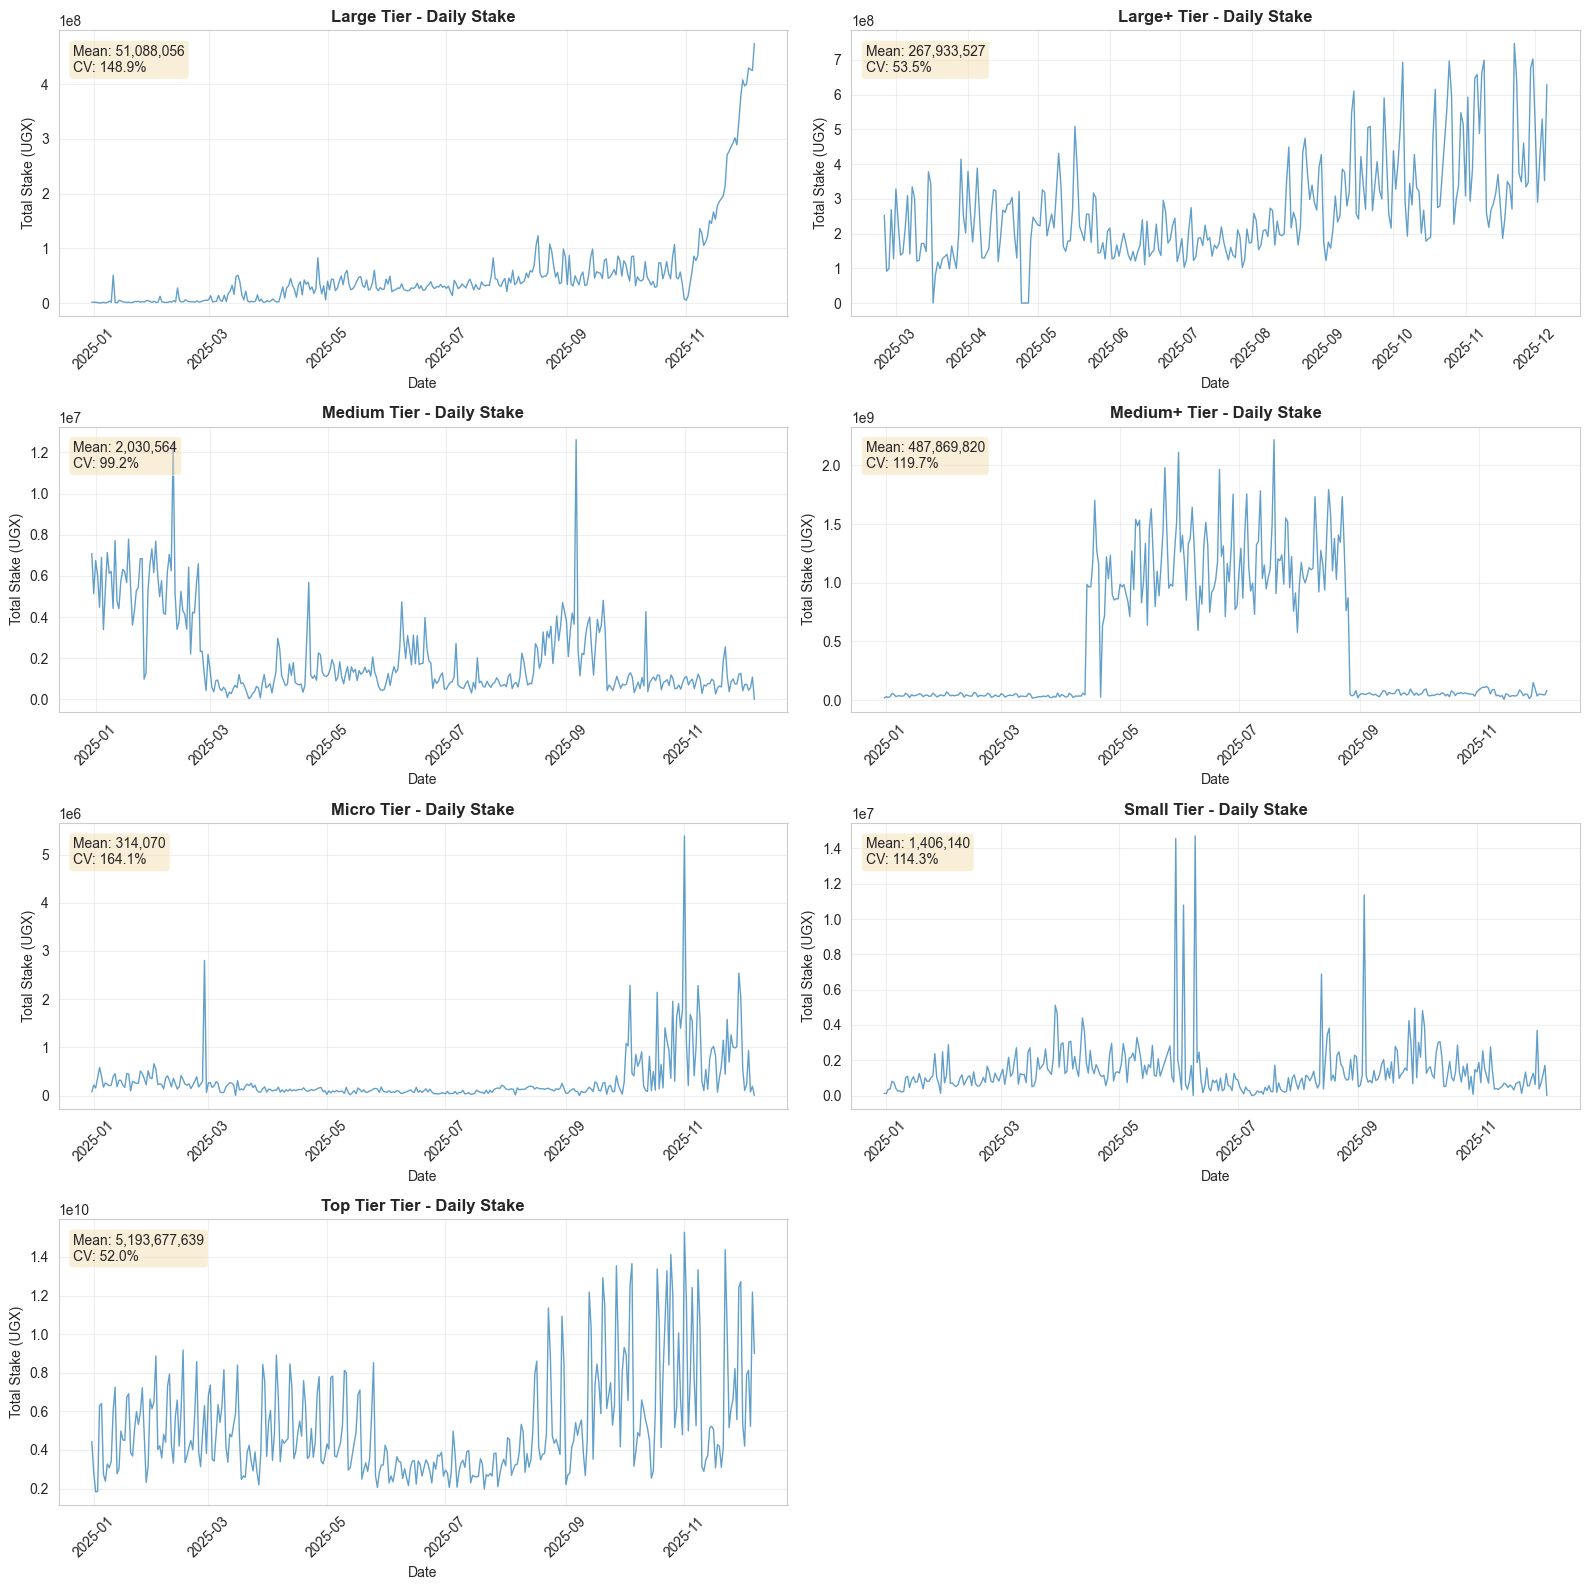


✓ Time series plots generated for all tiers


In [15]:
# Plot stake over time for each tier
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

tiers = sorted(tier_daily['operator_tier'].unique())

for i, tier in enumerate(tiers):
    tier_data = tier_daily[tier_daily['operator_tier'] == tier].copy()
    
    axes[i].plot(tier_data['date'], tier_data['total_stake'], linewidth=1, alpha=0.7)
    axes[i].set_title(f'{tier} Tier - Daily Stake', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Total Stake (UGX)')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)
    
    # Add basic stats
    mean_stake = tier_data['total_stake'].mean()
    std_stake = tier_data['total_stake'].std()
    cv = (std_stake / mean_stake) * 100
    axes[i].text(0.02, 0.95, f'Mean: {mean_stake:,.0f}\nCV: {cv:.1f}%', 
                 transform=axes[i].transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Remove extra subplots if tiers < 8
for i in range(len(tiers), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

print("\n✓ Time series plots generated for all tiers")

## 4. Autocorrelation Analysis

**Key Question:** Does stake(t) depend on stake(t-1), stake(t-7)?

We'll check ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) for each tier.

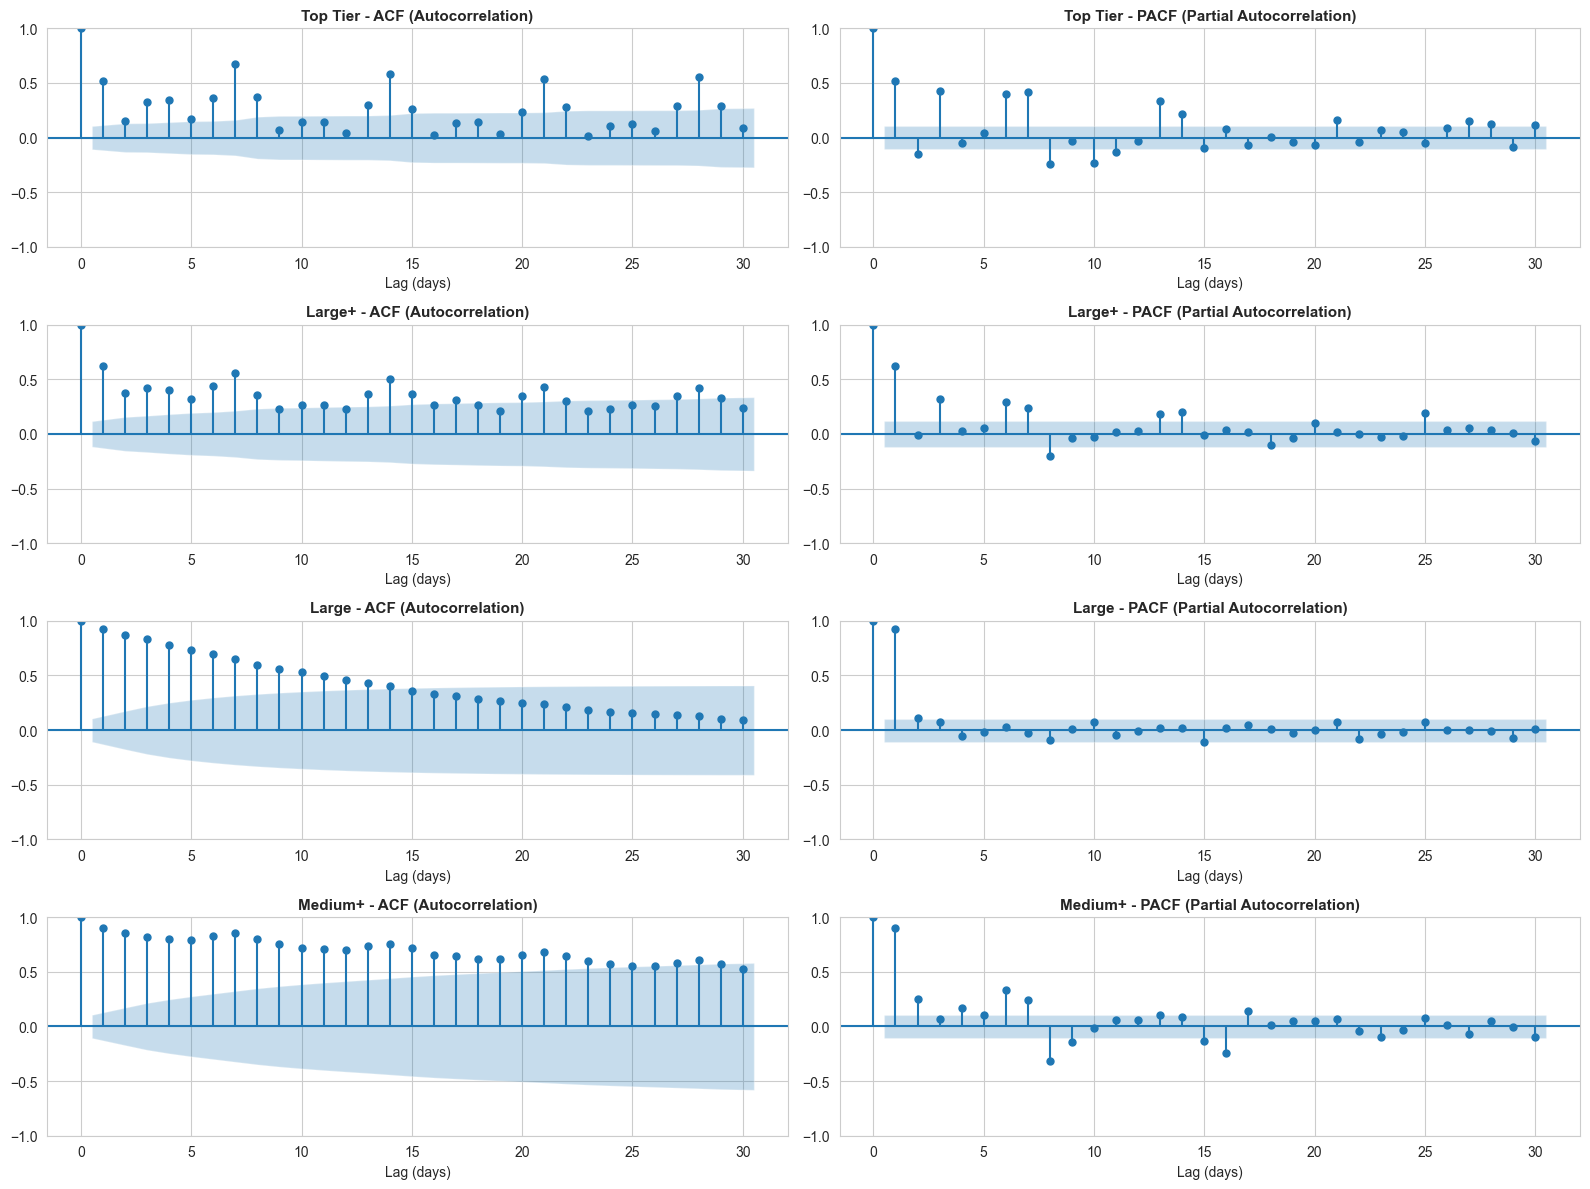


✓ Autocorrelation analysis complete

Key insights to look for:
  • Significant spike at lag-1: Yesterday's stake predicts today's
  • Significant spike at lag-7: Weekly cycle exists
  • Slow decay: Trend component present


In [16]:
# Focus on top 4 tiers with most data (Top Tier, Large+, Large, Medium+)
main_tiers = ['Top Tier', 'Large+', 'Large', 'Medium+']

fig, axes = plt.subplots(len(main_tiers), 2, figsize=(16, len(main_tiers) * 3))

for i, tier in enumerate(main_tiers):
    tier_data = tier_daily[tier_daily['operator_tier'] == tier].copy()
    tier_data = tier_data.sort_values('date')
    
    # ACF plot
    plot_acf(tier_data['total_stake'], lags=30, ax=axes[i, 0], alpha=0.05)
    axes[i, 0].set_title(f'{tier} - ACF (Autocorrelation)', fontsize=11, fontweight='bold')
    axes[i, 0].set_xlabel('Lag (days)')
    
    # PACF plot
    plot_pacf(tier_data['total_stake'], lags=30, ax=axes[i, 1], alpha=0.05, method='ywm')
    axes[i, 1].set_title(f'{tier} - PACF (Partial Autocorrelation)', fontsize=11, fontweight='bold')
    axes[i, 1].set_xlabel('Lag (days)')

plt.tight_layout()
plt.show()

print("\n✓ Autocorrelation analysis complete")
print("\nKey insights to look for:")
print("  • Significant spike at lag-1: Yesterday's stake predicts today's")
print("  • Significant spike at lag-7: Weekly cycle exists")
print("  • Slow decay: Trend component present")

## 5. Quantitative Autocorrelation Check

In [17]:
# Calculate specific lag correlations for all tiers
autocorr_results = []

for tier in tiers:
    tier_data = tier_daily[tier_daily['operator_tier'] == tier].copy()
    tier_data = tier_data.sort_values('date').reset_index(drop=True)
    
    # Calculate lagged correlations
    lag1_corr = tier_data['total_stake'].autocorr(lag=1)
    lag7_corr = tier_data['total_stake'].autocorr(lag=7)
    lag14_corr = tier_data['total_stake'].autocorr(lag=14)
    
    # Augmented Dickey-Fuller test (stationarity)
    adf_result = adfuller(tier_data['total_stake'].dropna())
    is_stationary = adf_result[1] < 0.05  # p-value < 0.05 means stationary
    
    autocorr_results.append({
        'Tier': tier,
        'Lag-1 Corr': lag1_corr,
        'Lag-7 Corr': lag7_corr,
        'Lag-14 Corr': lag14_corr,
        'Stationary': is_stationary,
        'ADF p-value': adf_result[1],
        'N_days': len(tier_data)
    })

autocorr_df = pd.DataFrame(autocorr_results)
autocorr_df = autocorr_df.round(3)

print("="*80)
print("AUTOCORRELATION ANALYSIS - STAKE BY TIER")
print("="*80)
print(autocorr_df.to_string(index=False))
print("\n" + "="*80)

# Interpretation
print("\n📊 INTERPRETATION:")
print("  • Lag-1 Corr > 0.5: Strong day-to-day persistence (use lag-1 feature)")
print("  • Lag-7 Corr > 0.3: Weekly cycle present (use lag-7 feature)")
print("  • Stationary = True: Can use linear models directly")
print("  • Stationary = False: May need differencing or detrending")

AUTOCORRELATION ANALYSIS - STAKE BY TIER
    Tier  Lag-1 Corr  Lag-7 Corr  Lag-14 Corr  Stationary  ADF p-value  N_days
   Large       0.972       0.932        0.840       False        0.999     341
  Large+       0.625       0.588        0.549       False        0.836     283
  Medium       0.753       0.702        0.565       False        0.219     343
 Medium+       0.900       0.861        0.775       False        0.519     341
   Micro       0.482       0.396        0.410       False        0.234     339
   Small       0.101       0.132        0.101        True        0.026     335
Top Tier       0.516       0.694        0.615       False        0.321     342


📊 INTERPRETATION:
  • Lag-1 Corr > 0.5: Strong day-to-day persistence (use lag-1 feature)
  • Lag-7 Corr > 0.3: Weekly cycle present (use lag-7 feature)
  • Stationary = True: Can use linear models directly
  • Stationary = False: May need differencing or detrending


## 6. Stake vs Number of Bets Relationship

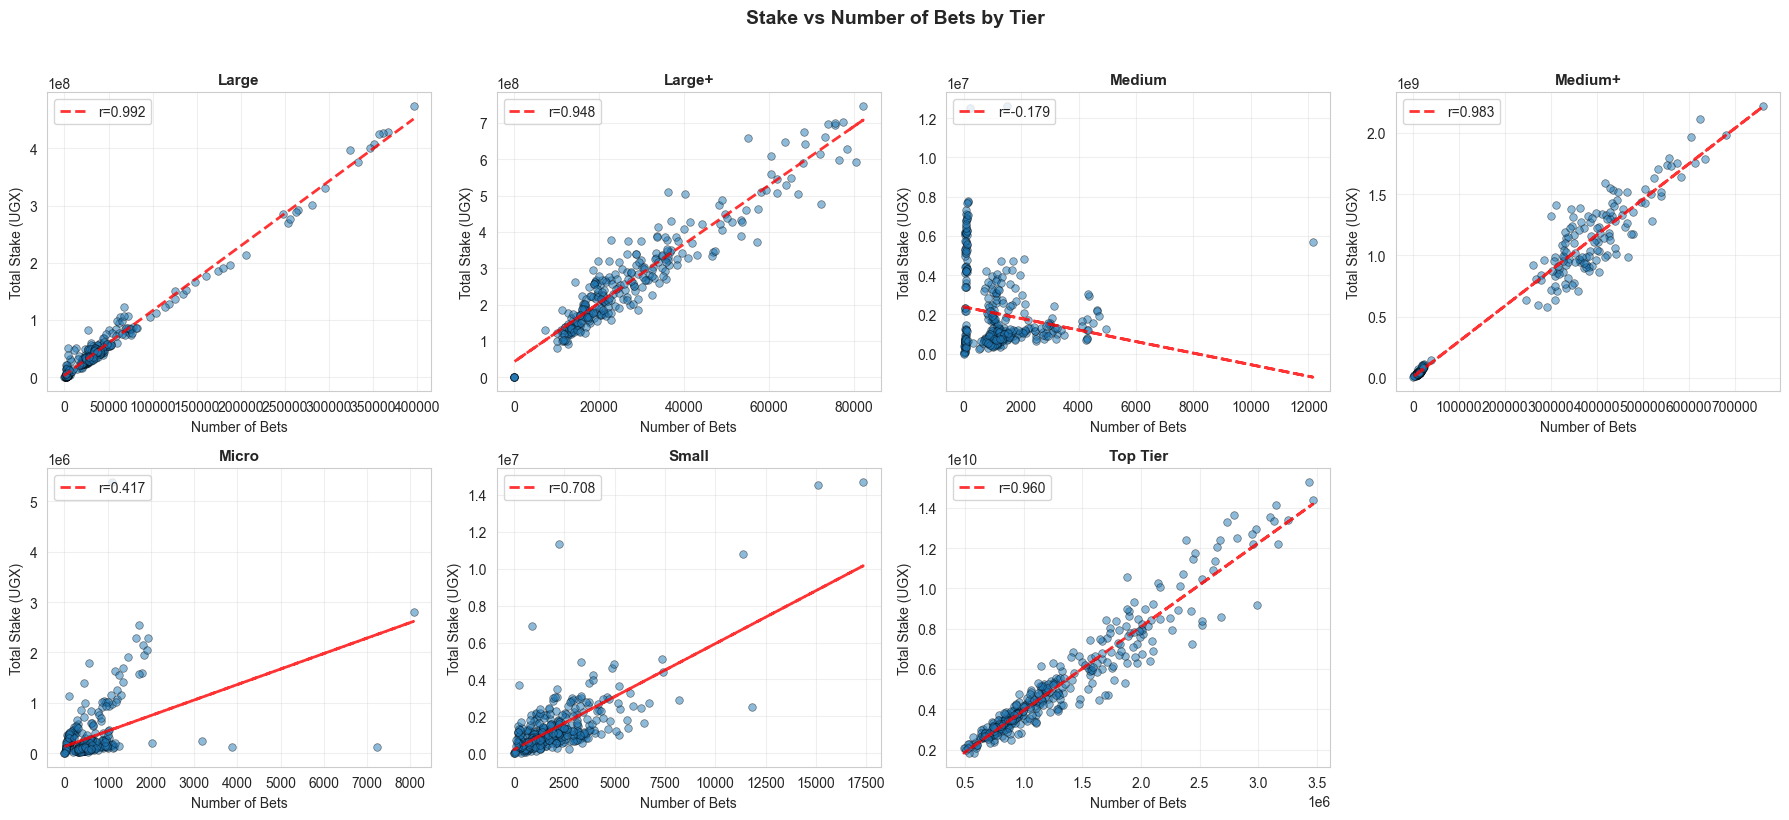


✓ Stake-Bets relationship analyzed


In [18]:
# Analyze relationship between stake and number of bets
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, tier in enumerate(tiers):
    tier_data = tier_daily[tier_daily['operator_tier'] == tier].copy()
    
    # Scatter plot with regression line
    axes[i].scatter(tier_data['total_bets'], tier_data['total_stake'], 
                   alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
    
    # Calculate correlation
    corr = tier_data[['total_bets', 'total_stake']].corr().iloc[0, 1]
    
    # Add trend line
    z = np.polyfit(tier_data['total_bets'], tier_data['total_stake'], 1)
    p = np.poly1d(z)
    axes[i].plot(tier_data['total_bets'], p(tier_data['total_bets']), 
                "r--", alpha=0.8, linewidth=2, label=f'r={corr:.3f}')
    
    axes[i].set_title(f'{tier}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Number of Bets')
    axes[i].set_ylabel('Total Stake (UGX)')
    axes[i].legend(loc='upper left')
    axes[i].grid(True, alpha=0.3)

# Remove extra subplots
for i in range(len(tiers), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Stake vs Number of Bets by Tier', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Stake-Bets relationship analyzed")

## 7. Game Category Mix Over Time

Check if game category distribution changes over time and affects stake.

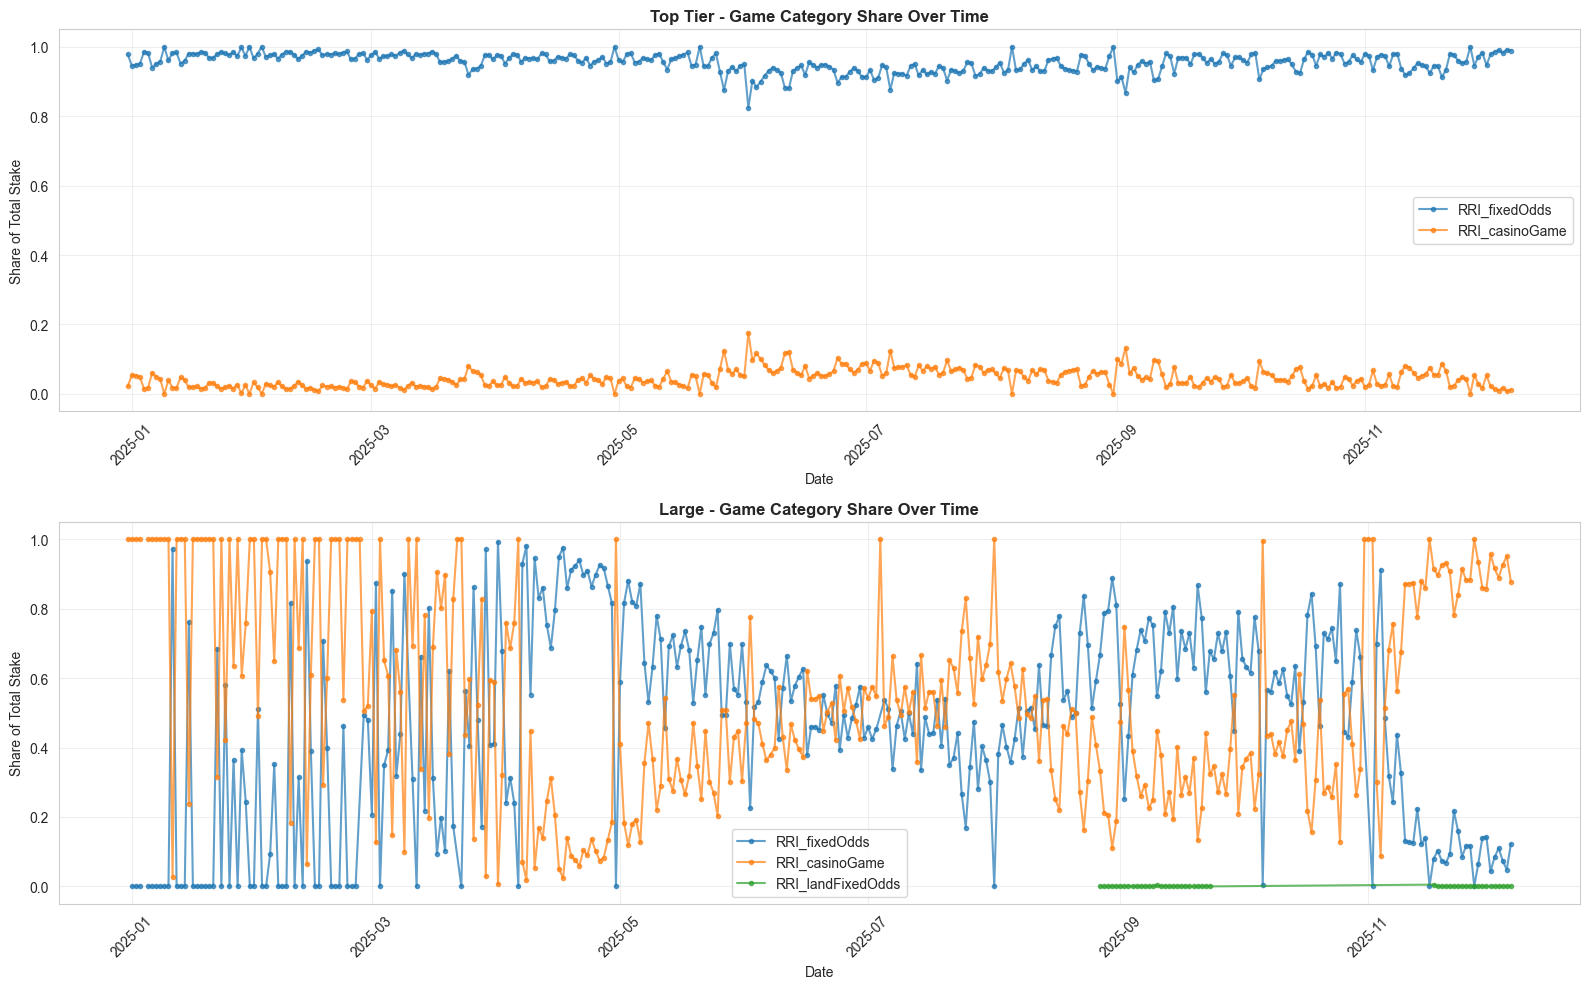


✓ Category mix analysis complete


In [8]:
# Calculate category shares per tier-day
category_shares = df.groupby(['date', 'operator_tier', 'game_category'])['total_stake'].sum().reset_index()
category_shares['stake_share'] = category_shares.groupby(['date', 'operator_tier'])['total_stake'].transform(lambda x: x / x.sum())

# Focus on main categories
main_categories = ['RRI_fixedOdds', 'RRI_fantasy', 'RRI_casinoGame', 'RRI_landFixedOdds']

# Plot for Top Tier and Large as examples
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

for i, tier in enumerate(['Top Tier', 'Large']):
    tier_cats = category_shares[category_shares['operator_tier'] == tier]
    
    for cat in main_categories:
        cat_data = tier_cats[tier_cats['game_category'] == cat]
        if len(cat_data) > 0:
            axes[i].plot(cat_data['date'], cat_data['stake_share'], 
                        marker='o', markersize=3, label=cat, alpha=0.7, linewidth=1.5)
    
    axes[i].set_title(f'{tier} - Game Category Share Over Time', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Share of Total Stake')
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Category mix analysis complete")

## 8. Create Time Series Features

Build candidate features for stake prediction models.

In [19]:
# Function to create time series features for a tier
def create_ts_features(tier_data):
    """
    Create time-series features for stake prediction.
    
    Features:
    - Autoregressive: stake_lag1, stake_lag7
    - Rolling stats: stake_ma7, stake_std7
    - Bet volume: bets_lag1, bets_current
    - Temporal: day_of_week, is_weekend
    """
    df_feat = tier_data.copy()
    df_feat = df_feat.sort_values('date').reset_index(drop=True)
    
    # Autoregressive features
    df_feat['stake_lag1'] = df_feat['total_stake'].shift(1)
    df_feat['stake_lag7'] = df_feat['total_stake'].shift(7)
    df_feat['stake_lag14'] = df_feat['total_stake'].shift(14)
    
    # Rolling statistics
    df_feat['stake_ma7'] = df_feat['total_stake'].rolling(window=7, min_periods=1).mean()
    df_feat['stake_std7'] = df_feat['total_stake'].rolling(window=7, min_periods=1).std()
    
    # Bet volume features
    df_feat['bets_current'] = df_feat['total_bets']
    df_feat['bets_lag1'] = df_feat['total_bets'].shift(1)
    df_feat['bets_ma7'] = df_feat['total_bets'].rolling(window=7, min_periods=1).mean()
    
    # Temporal features
    df_feat['day_of_week'] = pd.to_datetime(df_feat['date']).dt.dayofweek
    df_feat['is_weekend'] = (df_feat['day_of_week'] >= 5).astype(int)
    df_feat['week_of_year'] = pd.to_datetime(df_feat['date']).dt.isocalendar().week
    
    # Change features (momentum)
    df_feat['stake_pct_change'] = df_feat['total_stake'].pct_change()
    df_feat['bets_pct_change'] = df_feat['total_bets'].pct_change()
    
    return df_feat

# Create features for each tier
tier_features = {}
for tier in tiers:
    tier_data = tier_daily[tier_daily['operator_tier'] == tier].copy()
    tier_features[tier] = create_ts_features(tier_data)

# Show example for Top Tier
print("Example features for Top Tier:")
print("="*80)
display(tier_features['Top Tier'][[
    'date', 'total_stake', 'stake_lag1', 'stake_lag7', 'stake_ma7',
    'bets_current', 'bets_lag1', 'day_of_week', 'is_weekend'
]].head(15))

print("\n✓ Time series features created for all tiers")

Example features for Top Tier:


,date,total_stake,stake_lag1,stake_lag7,stake_ma7,bets_current,bets_lag1,day_of_week,is_weekend
0,2024-12-31,4.439151e+09,NaN,NaN,4.439151e+09,1637098.0,NaN,1,0
1,2025-01-01,2.827168e+09,4.439151e+09,NaN,3.633160e+09,978005.0,1637098.0,2,0
2,2025-01-02,1.834836e+09,2.827168e+09,NaN,3.033718e+09,571180.0,978005.0,3,0
3,2025-01-03,1.846064e+09,1.834836e+09,NaN,2.736805e+09,529850.0,571180.0,4,0
4,2025-01-04,6.289059e+09,1.846064e+09,NaN,3.447256e+09,1961881.0,529850.0,5,1
5,2025-01-05,6.404297e+09,6.289059e+09,NaN,3.940096e+09,2078296.0,1961881.0,6,1
6,2025-01-06,2.748004e+09,6.404297e+09,NaN,3.769797e+09,953421.0,2078296.0,0,0
7,2025-01-07,2.381633e+09,2.748004e+09,4.439151e+09,3.475866e+09,742759.0,953421.0,1,0
8,2025-01-08,3.274607e+09,2.381633e+09,2.827168e+09,3.539786e+09,963541.0,742759.0,2,0
9,2025-01-09,3.073195e+09,3.274607e+09,1.834836e+09,3.716694e+09,864626.0,963541.0,3,0



✓ Time series features created for all tiers


## 9. Feature Correlation with Stake

Which features are most predictive of stake?

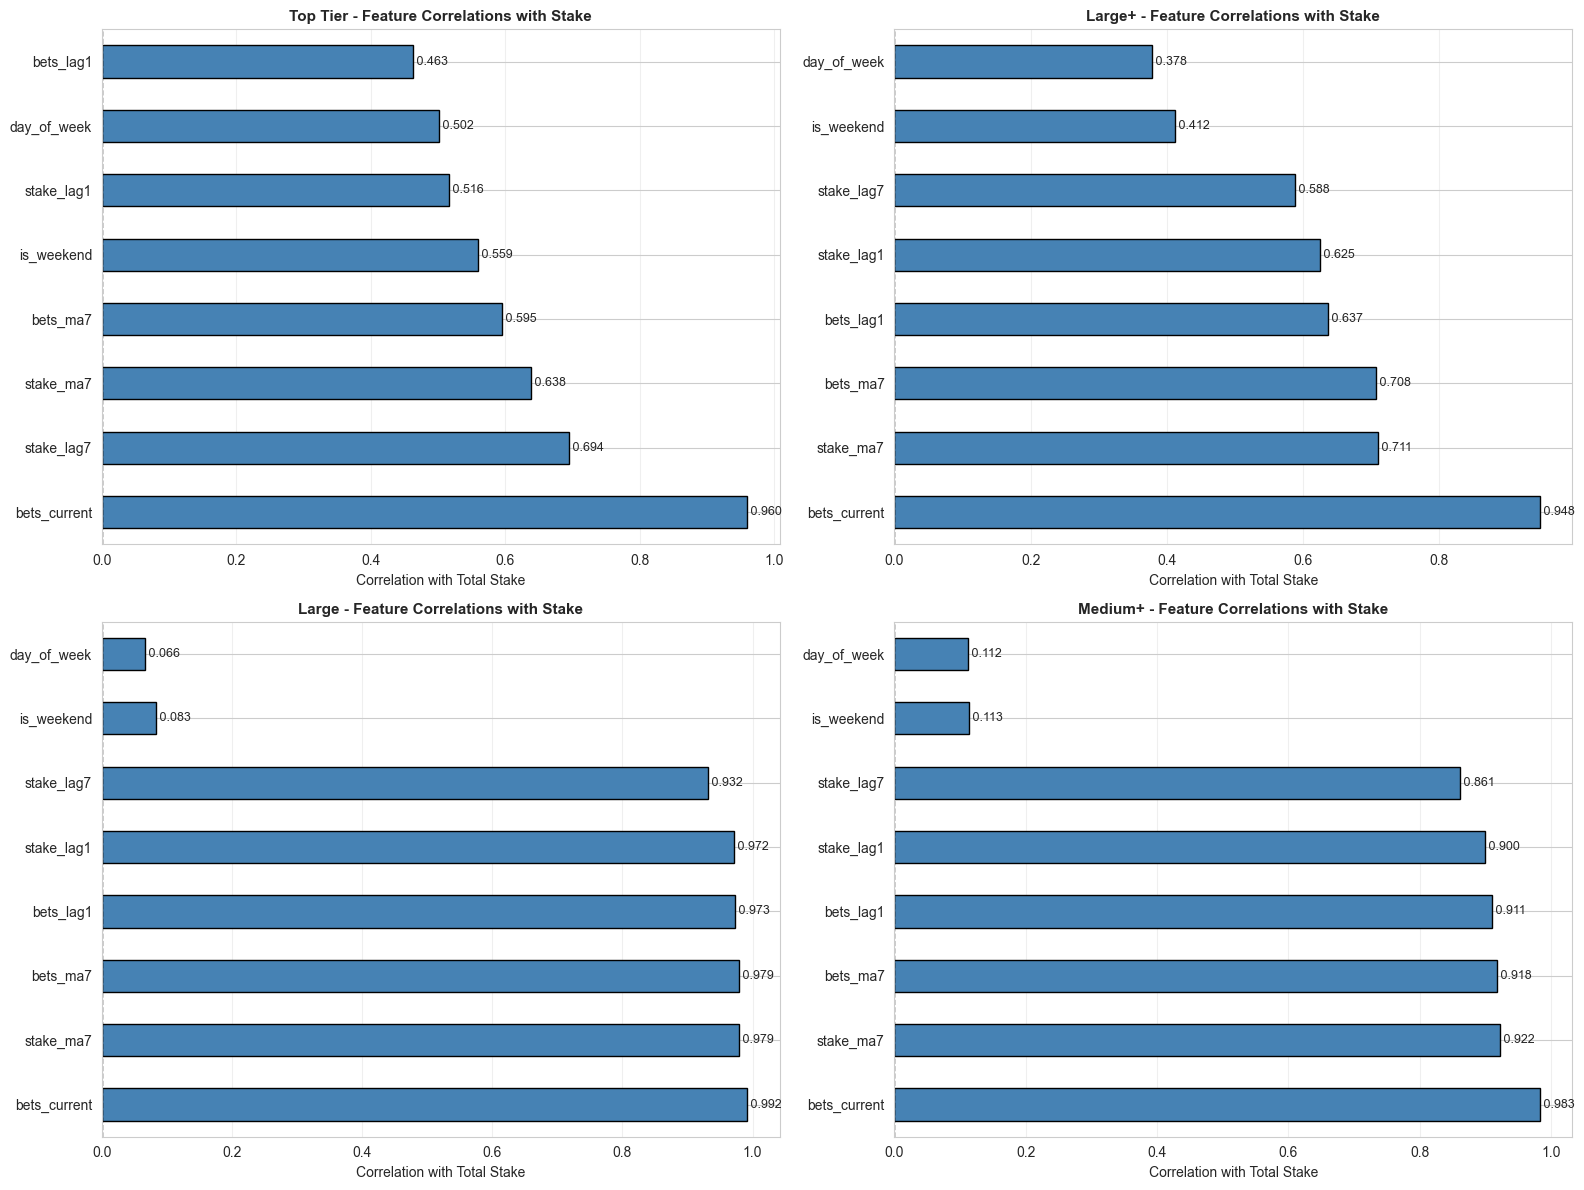


✓ Feature importance analysis complete


In [20]:
# Calculate feature correlations for main tiers
feature_cols = ['stake_lag1', 'stake_lag7', 'stake_ma7', 'bets_current', 
                'bets_lag1', 'bets_ma7', 'day_of_week', 'is_weekend']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, tier in enumerate(main_tiers):
    tier_data = tier_features[tier].copy()
    
    # Calculate correlations with total_stake
    correlations = tier_data[feature_cols + ['total_stake']].corr()['total_stake'].drop('total_stake').sort_values(ascending=False)
    
    # Plot
    correlations.plot(kind='barh', ax=axes[i], color='steelblue', edgecolor='black')
    axes[i].set_title(f'{tier} - Feature Correlations with Stake', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Correlation with Total Stake')
    axes[i].axvline(x=0, color='k', linestyle='--', linewidth=1)
    axes[i].grid(True, alpha=0.3, axis='x')
    
    # Add correlation values on bars
    for j, (idx, val) in enumerate(correlations.items()):
        axes[i].text(val, j, f' {val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis complete")

## 10. Summary: Can We Model Stake with Time Series Features?

Based on EDA above, answer key questions.

In [21]:
print("="*80)
print("STAKE FORECASTING - EDA SUMMARY")
print("="*80)

print("\n1️⃣ DOES STAKE DEPEND ON ITSELF (AUTOREGRESSIVE)?")
print("-" * 80)
strong_ar = autocorr_df[autocorr_df['Lag-1 Corr'] > 0.5]['Tier'].tolist()
moderate_ar = autocorr_df[(autocorr_df['Lag-1 Corr'] > 0.3) & (autocorr_df['Lag-1 Corr'] <= 0.5)]['Tier'].tolist()
weak_ar = autocorr_df[autocorr_df['Lag-1 Corr'] <= 0.3]['Tier'].tolist()

print(f"  Strong AR (lag-1 > 0.5): {strong_ar}")
print(f"  Moderate AR (0.3-0.5): {moderate_ar}")
print(f"  Weak AR (< 0.3): {weak_ar}")
print(f"\n  ✓ Conclusion: {len(strong_ar) + len(moderate_ar)}/{len(tiers)} tiers show AR behavior")
print("    → Use stake_lag1 and stake_lag7 as features")

print("\n2️⃣ ARE THERE WEEKLY CYCLES (LAG-7)?")
print("-" * 80)
weekly_cycle = autocorr_df[autocorr_df['Lag-7 Corr'] > 0.3]['Tier'].tolist()
print(f"  Tiers with weekly cycle: {weekly_cycle}")
print(f"\n  ✓ Conclusion: {len(weekly_cycle)}/{len(tiers)} tiers have weekly patterns")
print("    → Include day_of_week and is_weekend features")

print("\n3️⃣ DOES NUMBER OF BETS PREDICT STAKE?")
print("-" * 80)
# Calculate stake-bets correlation for each tier
stake_bets_corr = []
for tier in tiers:
    tier_data = tier_daily[tier_daily['operator_tier'] == tier]
    corr = tier_data[['total_bets', 'total_stake']].corr().iloc[0, 1]
    stake_bets_corr.append({'Tier': tier, 'Stake-Bets Corr': corr})

corr_df = pd.DataFrame(stake_bets_corr).sort_values('Stake-Bets Corr', ascending=False)
print(corr_df.round(3).to_string(index=False))

strong_corr = corr_df[corr_df['Stake-Bets Corr'] > 0.7]['Tier'].tolist()
print(f"\n  ✓ Conclusion: {len(strong_corr)}/{len(tiers)} tiers have strong stake-bets correlation (>0.7)")
print("    → Use bets_current and bets_lag1 as key features")

print("\n4️⃣ IS DATA STATIONARY (READY FOR LINEAR MODELS)?")
print("-" * 80)
stationary_tiers = autocorr_df[autocorr_df['Stationary'] == True]['Tier'].tolist()
non_stationary = autocorr_df[autocorr_df['Stationary'] == False]['Tier'].tolist()
print(f"  Stationary: {stationary_tiers}")
print(f"  Non-stationary: {non_stationary}")
print(f"\n  ✓ Conclusion: {len(stationary_tiers)}/{len(tiers)} tiers are stationary")
if len(non_stationary) > 0:
    print("    → For non-stationary tiers, use differencing or detrending")
else:
    print("    → All tiers ready for linear modeling")

print("\n" + "="*80)
print("📊 RECOMMENDATION: LINEAR MODELS WITH TIME-SERIES FEATURES")
print("="*80)
print("\nModel per tier with features:")
print("  ✓ Autoregressive: stake_lag1, stake_lag7, stake_ma7")
print("  ✓ Bet volume: bets_current, bets_lag1, bets_ma7")
print("  ✓ Temporal: day_of_week, is_weekend")
print("  ✓ Game category shares (to be added from df)")
print("\nNext steps:")
print("  1. Build tier-specific linear regression models")
print("  2. Use 70/30 chronological train-test split")
print("  3. Validate on test period (no shuffling!)")
print("  4. Compare to naive baseline (yesterday's stake)")
print("="*80)

STAKE FORECASTING - EDA SUMMARY

1️⃣ DOES STAKE DEPEND ON ITSELF (AUTOREGRESSIVE)?
--------------------------------------------------------------------------------
  Strong AR (lag-1 > 0.5): ['Large', 'Large+', 'Medium', 'Medium+', 'Top Tier']
  Moderate AR (0.3-0.5): ['Micro']
  Weak AR (< 0.3): ['Small']

  ✓ Conclusion: 6/7 tiers show AR behavior
    → Use stake_lag1 and stake_lag7 as features

2️⃣ ARE THERE WEEKLY CYCLES (LAG-7)?
--------------------------------------------------------------------------------
  Tiers with weekly cycle: ['Large', 'Large+', 'Medium', 'Medium+', 'Micro', 'Top Tier']

  ✓ Conclusion: 6/7 tiers have weekly patterns
    → Include day_of_week and is_weekend features

3️⃣ DOES NUMBER OF BETS PREDICT STAKE?
--------------------------------------------------------------------------------
    Tier  Stake-Bets Corr
   Large            0.992
 Medium+            0.983
Top Tier            0.960
  Large+            0.948
   Small            0.708
   Micro         